In [1]:
import os
import statistics
import scipy as sp
import math
import pandas as pd
#pd.get_option("display.max_rows")
#pd.reset_option("display.max_rows")
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
%matplotlib inline

In [2]:
os.chdir(' ') #set proper directory depending where you put that project
#data - data for 2019/2020
#data05 - data for 2017/2018
#data1 - data for 2018/19
#data15 - data for 2020/21
data = pd.read_csv('danelic2019.csv',sep=';',engine='python')
data05 =  pd.read_csv('danelic2017.csv',sep=';',engine='python')
data1 = pd.read_csv('danelic2018.csv',sep=';',engine='python')
#data15 = pd.read_csv('danelic2020.csv',sep=';',engine='python')
data1=pd.DataFrame.append(data,data1)
data1=pd.DataFrame.append(data1,data05,ignore_index=True)
#data1=pd.DataFrame.append(data1,data15,ignore_index=True)
data1.sort_values('player')

,ď»żColumn1,player,nationality,position,squad,age,birth_year,value,height,position2,...,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,Column1,Unnamed: 0
466,546.0,Aaron Connolly,ie IRL,FW,Brighton,19.0,2000.0,4000000.0,175.0,Forward - Centre-Forward,...,54.5,-13.3,-0.35,22369,0.0,0.0,0.0,201920#,NaN,NaN
7066,NaN,Aaron Cresswell,eng ENG,DF,West Ham,27.0,1989.0,12000000.0,170.0,Defender - Left-Back,...,57.8,-20.5,-0.54,56885,0.0,0.0,0.0,201718#,NaN,574.0
4691,NaN,Aaron Cresswell,eng ENG,DF,West Ham,28.0,1989.0,10000000.0,170.0,Defender - Left-Back,...,61.0,-11.9,-0.31,58336,0.0,0.0,0.0,201819#,542.0,NaN
2576,582.0,Aaron Cresswell,eng ENG,DF,West Ham,29.0,1989.0,6000000.0,170.0,Defender - Left-Back,...,61.1,-14.8,-0.39,44155,0.0,0.0,NaN,201920#,NaN,NaN
5688,NaN,Aaron Hunt,de GER,"MF,FW",Hamburger SV,30.0,1986.0,1500000.0,183.0,midfield - Attacking Midfield,...,52.7,-15.7,-0.46,50656,0.0,0.0,0.0,201718#,NaN,1120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [3]:
#adding dummy variables to dataset
data1 = pd.get_dummies(data1, columns=['league'])
data1 = data1.rename({"league_Bundesliga":"isBundesliga",
                                "league_La Liga":"isLaLiga",
                                "league_Premier League":"isPremierLeague",
                                "league_Ligue 1":"isLigue1",
                                "league_Serie A":"isSerieA"},axis='columns')
data1=pd.get_dummies(data1,columns=['Season'])
data1=pd.get_dummies(data1,columns=['foot'])
#deleting potential outliers that actually contribute nothing
data1=data1[data1['value']>1000000]
data1=data1[data1['games']>5]
data1=data1[data1['age']>0]
data1=data1[data1['height']>0]
data1

,ď»żColumn1,player,nationality,position,squad,age,birth_year,value,height,position2,...,isLaLiga,isLigue1,isPremierLeague,isSerieA,Season_201718#,Season_201819#,Season_201920#,foot_both,foot_left,foot_right
0,21.0,Martin Aguirregabiria,es ESP,DF,AlavÄ‚Â©s,23.0,1996.0,4000000.0,178.0,Defender - Right-Back,...,1,0,0,0,0,0,1,0,0,1
1,390.0,Oliver Burke,sco SCO,"MF,FW",AlavÄ‚Â©s,22.0,1997.0,4000000.0,188.0,Forward - Right Winger,...,1,0,0,0,0,0,1,0,0,1
2,430.0,VÄ‚Â­ctor Camarasa,es ESP,MF,AlavÄ‚Â©s,25.0,1994.0,4000000.0,183.0,Midfielder - Central Midfield,...,1,0,0,0,0,0,1,0,0,1
3,737.0,RubÄ‚Â©n Duarte,es ESP,DF,AlavÄ‚Â©s,23.0,1995.0,4000000.0,172.0,Defender - Left-Back,...,1,0,0,0,0,0,1,0,1,0
5,826.0,Ljubomir Fejsa,rs SRB,MF,AlavÄ‚Â©s,30.0,1988.0,2000000.0,183.0,Midfielder - Defensive Midfield,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7094,NaN,Mario GĂłmez,de GER,FW,Wolfsburg,32.0,1985.0,6000000.0,189.0,attack - Centre-Forward,...,0,0,0,0,1,0,0,0,0,1
7095,NaN,Josuha Guilavogui,fr FRA,MF,Wolfsburg,26.0,1990.0,7000000.0,188.0,midfield - Defensive Midfield,...,0,0,0,0,1,0,0,0,0,1
7102,NaN,Divock Origi,be BEL,FW,Wolfsburg,22.0,1995.0,10000000.0,185.0,attack - Centre-Forward,...,0,0,0,0,1,0,0,0,0,1
7104,NaN,Renato Steffen,ch SUI,"FW,MF",Wolfsburg,25.0,1991.0,3500000.0,170.0,attack - Right Winger,...,0,0,0,0,1,0,0,0,1,0


In [4]:
#DEFENDERS
dataDEF = data1[data1['position2'].str[:8]=='Defender']
dataDEF

,ď»żColumn1,player,nationality,position,squad,age,birth_year,value,height,position2,...,isLaLiga,isLigue1,isPremierLeague,isSerieA,Season_201718#,Season_201819#,Season_201920#,foot_both,foot_left,foot_right
0,21.0,Martin Aguirregabiria,es ESP,DF,AlavÄ‚Â©s,23.0,1996.0,4000000.0,178.0,Defender - Right-Back,...,1,0,0,0,0,0,1,0,0,1
3,737.0,RubÄ‚Â©n Duarte,es ESP,DF,AlavÄ‚Â©s,23.0,1995.0,4000000.0,172.0,Defender - Left-Back,...,1,0,0,0,0,0,1,0,1,0
9,1347.0,VÄ‚Â­ctor Laguardia,es ESP,DF,AlavÄ‚Â©s,29.0,1989.0,7000000.0,185.0,Defender - Centre-Back,...,1,0,0,0,0,0,1,0,0,1
12,1494.0,Lisandro MagallÄ‚Ë‡n,ar ARG,DF,AlavÄ‚Â©s,25.0,1993.0,4000000.0,185.0,Defender - Centre-Back,...,1,0,0,0,0,0,1,0,0,1
17,1763.0,Ximo Navarro,es ESP,DF,AlavÄ‚Â©s,29.0,1990.0,2000000.0,176.0,Defender - Right-Back,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046,NaN,Kieran Gibbs,eng ENG,DF,West Brom,27.0,1989.0,8000000.0,180.0,Defender - Left-Back,...,0,0,1,0,1,0,0,0,1,0
7054,NaN,Allan Nyom,cm CMR,DF,West Brom,29.0,1988.0,4500000.0,189.0,Defender - Right-Back,...,0,0,1,0,1,0,0,0,0,1
7066,NaN,Aaron Cresswell,eng ENG,DF,West Ham,27.0,1989.0,12000000.0,170.0,Defender - Left-Back,...,0,0,1,0,1,0,0,0,1,0
7076,NaN,Arthur Masuaku,cd COD,"MF,DF",West Ham,23.0,1993.0,7000000.0,179.0,Defender - Left-Back,...,0,0,1,0,1,0,0,0,1,0


In [ ]:
#was originally used for correlations calculations (visible in appendix)

#dataDEF['age']=dataDEF['age']*dataDEF['age']
#dataDEF_cor = dataDEF.corr()
#show=pd.Series(dataDEF_cor['value'])
#pd.set_option('display.max_rows', None)
#show.sort_values(ascending=False)

In [6]:
#a cosmetic change in log notation for my liking
def ln(x):
    return np.log(x)

dataDEF['pctpassesshort']=(dataDEF['passes_short']/dataDEF['passes'])/dataDEF['minutes']
dataDEF['pctpassesmedium']=(dataDEF['passes_medium']/dataDEF['passes'])/dataDEF['minutes']
dataDEF['pctpasseslong']=(dataDEF['passes_long']/dataDEF['passes'])/dataDEF['minutes']
dataDEF['pctpassescompleted']=dataDEF['passes_completed']/dataDEF['passes']/dataDEF['minutes']
#Creating a linear regression
trainDEF, testDEF = train_test_split(dataDEF, train_size=0.8)
modelDEF=smf.ols('ln(value)~age+CL+goals+xg_xa_per90+'
                  'passes_ground+touches_att_pen_area+touches_def_pen_area+aerials_won_pct'
                   '+'
                   ''
                   '+isPremierLeague+isLigue1'
                   '+Pts+xGA+xG',data=dataDEF)
modelDEF1=smf.ols('value~wins_gk+clean_sheets+Pts+W+GDiff+clean_sheets_pct+CL+xGDiff+GF+xG+passes_ground+passes_completed_medium+passes_medium+games+games_starts+minutes_90s+minutes+games_gk+games_starts_gk+minutes_90s_gk+minutes_gk+passes_throws_gk+passes_other_body+passes_completed+passes_received+passes_live+pass_targets+carries+touches_live_ball+passes_pct_long+touches_def_pen_area+passes_completed_short+passes_gk+passes_pressure+passes_pct+def_actions_outside_pen_area_gk+passes_total_distance+psxg_net_gk+touches_def_3rd+passes_short+passes+touches+ball_recoveries+through_balls+dribble_tackles_pct+psxg_net_per90_gk+passes_pct_launched_gk+save_pct+passes_low+xa_net+passes_progressive_distance+WinCL+carry_distance+gca_passes_dead+errors+passes_switches+passes_completed_long+crosses_gk+passes_intercepted+crosses_stopped_gk+dribbles_completed_pct+passes_left_foot+carry_progressive_distance+isPremierLeague+MP+avg_distance_def_actions_gk+saves+draws_gk+assists+goal_kicks+gca+foot_left+isLaLiga+passes_right_foot+shots_on_target_against+passes_pct_short+aerials_won_pct+passes_dead+assists_per90+gca_per90+passes_completed_launched_gk+passes_long+sca_passes_dead+def_actions_outside_pen_area_per90_gk+passes_pct_medium+crosses_stopped_pct_gk+passes_oob+own_goals_against_gk+gca_passes_live+pens_conceded+shots_on_target_pct+throw_ins+psxg_gk+pens_missed_gk+goals_assists_pens_per90+passes_received_pct+height+pens_allowed+goals_assists_per90+passes_launched_gk+npxg_net+pens_att_gk+cards_red+sca+xg_net+sca_passes_live+passes_high+fouled+free_kick_goals_against_gk+cards_yellow+corner_kicks_in+xa+passes_offsides+pens_saved+dribbles_completed+dribble_tackles+assisted_shots+players_dribbled_past+npxg_per_shot+xa_per90+passes_into_penalty_area+pressure_regain_pct+tackles_def_3rd+passes_free_kicks+miscontrols+dribbles+dribbles_vs+passes_head+isSerieA+clearances+corner_kick_goals_against_gk+dribbled_past+corner_kicks+shots_on_target_per90+tackles+goals_against_gk+pressures_def_3rd+tackles_won+dispossessed+tackles_mid_3rd+fouls+shots_total_per90+progressive_passes+offsides+npxg_xa_per90+xg_xa_per90+goals_pens_per90+passes_blocked+touches_mid_3rd+aerials_won+shots_on_target+sca_dribbles+gca_shots+pens_att+pens_made+pens_won+nutmegs+goals_per90+crosses+pressures+blocked_shots+pressure_regains+interceptions+goals_per_shot+shots_total+pressures_mid_3rd+shots_free_kicks+touches_att_pen_area+goals+sca_fouled+pressures_att_3rd+aerials_lost+touches_att_3rd+tackles_att_3rd+xg+goals_per_shot_on_target+own_goals+npxg+sca_shots+npxg_per90+xg_per90+blocks+blocked_passes+sca_per90+crosses_into_penalty_area+passes_into_final_third+D+psnpxg_per_shot_on_target_against+goal_kick_length_avg+foot_right+isBundesliga+isLigue1+passes_length_avg_gk+pct_goal_kicks_launched+losses_gk+pct_passes_launched_gk+age+goals_against_per90_gk+xGA+GA+L+LgRk+gca_dribbles+gca_fouled+gca_og_for+corner_kicks_out+corner_kicks_straight+foot_both+cards_yellow_red+blocked_shots_saves',data=dataDEF)    

#progressive_passesm
resultsDEF=modelDEF.fit()
resultsDEF_params=resultsDEF.params
resultsDEF1=modelDEF1.fit()
resultsDEF1_params=resultsDEF1.params
#Creating a robust regression
modelDEFrobust=sm.RLM(modelDEF.endog,modelDEF.exog,data=trainDEF).fit()
#r2_wls = sm.WLS(modelGK.endog, modelGK.exog, weights=modelGKrobust.weights).fit().rsquared
#modelGKrobustridge = sm.WLS(modelGK.endog, modelGK.exog, weights=modelGKrobust.weights).fit_regularized(alpha=0.2, L1_wt=0,start_params=resultsGK_params)
#print(modelGKrobust.summary(),
      #"R^2:", r2_wls)
finalDEF1 = sm.regression.linear_model.OLSResults(modelDEF, 
                                              modelDEFrobust.params, 
                                              modelDEF.normalized_cov_params)
#print(resultsDEF.get_robustcov_results(cov_type='HC1').summary())
finalDEF1.summary()
#ball recoveries, dribbled past, passes head - to describe
#print('do not bother about it printing summary like for OLS - this is a robust regression as you can see from the code')

<ipython-input-6-f55290443f8b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDEF['pctpassesshort']=(dataDEF['passes_short']/dataDEF['passes'])/dataDEF['minutes']
<ipython-input-6-f55290443f8b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDEF['pctpassesmedium']=(dataDEF['passes_medium']/dataDEF['passes'])/dataDEF['minutes']
<ipython-input-6-f55290443f8b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ln(value)   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     219.3
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:52:47   Log-Likelihood:                -1494.2
No. Observations:                1674   AIC:                             3016.
Df Residuals:                    1660   BIC:                             3092.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               16.7882      0.186     90.073      0.000      16.423      17.154
age                     -0.0937      0.004    -22.664      0.000      -0.102      -0.086
CL                       0.2775      0.056      4.958      0.000       0.168       0.387
goals                    0.0323      0.014      2.238      0.025       0.004       0.061
xg_xa_per90              0.9020      0.294      3.063      0.002       0.324       1.479
passes_ground            0.0006   6.18e-05      9.231      0.000       0.000       0.001
touches_att_pen_area     0.0058      0.001      5.143      0.000       0.004       0.008
touches_def_pen_area     0.0019      0.000      6.293      0.000       0.001       0.002
aerials_won_pct          0.0024      0.001      2.069      0.039       0.000       0.005
isPremierLeague          0.5194      0.035     14.656      0.000       0.450       0.589
isLigue1                -0.2413      0.042     -5.712      0.000      -0.324      -0.158
Pts                      0.0101      0.002      5.385      0.000       0.006       0.014
xGA                     -0.0154      0.002     -7.320      0.000      -0.020      -0.011
xG                       0.0079      0.002      3.695      0.000       0.004       0.012
==============================================================================
Omnibus:                       16.016   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.062
Skew:                           0.178   Prob(JB):                     0.000120
Kurtosis:                       3.364   Cond. No.                     1.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif = pd.DataFrame()
vif["features"] = modelDEF.exog_names
vif["VIF Factor"] = [variance_inflation_factor(finalDEF1.model.exog, i) for i in range(finalDEF1.model.exog.shape[1])]
vif

,features,VIF Factor
0,Intercept,165.236019
1,age,1.064045
2,CL,2.489913
3,goals,1.536241
4,xg_xa_per90,2.060810
5,passes_ground,3.011651
6,touches_att_pen_area,2.071024
7,touches_def_pen_area,2.700572
8,aerials_won_pct,1.242972
9,isPremierLeague,1.115603


In [10]:
#testing
#Breusch-Pagan
bptestDEF=sm.stats.diagnostic.het_breuschpagan(finalDEF1.resid, finalDEF1.model.exog)
bptestDEF

(19.338644081421705,
 0.11297238946178545,
 1.4923876003776353,
 0.11257792322101462)

In [12]:
#Chowtest
trainDEF1=dataDEF[dataDEF['Season_201819#']==0]
trainDEF2=dataDEF[dataDEF['Season_201819#']==1]
JDEF = len(resultsDEF.params)-1 #number of coefficients
N1DEF = trainDEF1.shape[0]
N2DEF = trainDEF2.shape[0]
RSSdDEF=resultsDEF.ssr
resultsDEFridge1=smf.ols('ln(value)~age+CL+goals+xg_xa_per90+'
                  'passes_ground+touches_att_pen_area+touches_def_pen_area+aerials_won_pct'
                   '+'
                   ''
                   '+isPremierLeague+isLigue1'
                   '+Pts+xGA+xG',data=trainDEF1).fit()
RSSbDEF=resultsDEFridge1.ssr
kDEF = len(resultsDEFridge1.params)-1
resultsDEFridge2=smf.ols('ln(value)~age+CL+goals+xg_xa_per90+'
                  'passes_ground+touches_att_pen_area+touches_def_pen_area+aerials_won_pct'
                   '+'
                   ''
                   '+isPremierLeague+isLigue1'
                   '+Pts+xGA+xG',data=trainDEF2).fit()
RSSnbDEF = resultsDEFridge2.ssr
ChowDEF=((RSSdDEF-(RSSbDEF+RSSnbDEF))/JDEF)/((RSSbDEF+RSSnbDEF)/(N1DEF+N2DEF-2*kDEF))
pDEF=sp.stats.f.cdf(ChowDEF, JDEF, N1DEF+N2DEF-2*kDEF)
print(ChowDEF,pDEF,JDEF)

2.254414022896363 0.9937604081109251 13


In [15]:
predictionsDEF=finalDEF1.predict(dataDEF)
dataDEF['predsOLS']=np.exp(predictionsDEF)
#DEFpredtrain=resultsDEF.predict(trainDEF)
#DEFpredtest=resultsDEF.predict(testDEF)
#rmsetrainDEF=sm.tools.eval_measures.rmse(trainDEF['value'],np.exp(DEFpredtrain))
#rmsetestDEF=sm.tools.eval_measures.rmse(testDEF['value'],np.exp(DEFpredtest))
#print(rmsetrainDEF,rmsetestDEF)

<ipython-input-15-3137fbb00fc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDEF['predsOLS']=np.exp(predictionsDEF)


In [17]:
#cross validation
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        #self.results_ = self.model_.fit_regularized(L1_wt=1, alpha=0.1,start_params=resultsDEF_params)
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

linearcval=cross_val_score(SMWrapper(sm.RLM), modelDEF.exog, modelDEF.endog, scoring='neg_root_mean_squared_error')
pd.DataFrame(pd.Series(np.transpose(linearcval)))
#robustcval=cross_val_score(SMWrapper(sm.RLM), modelDEF.exog, modelDEF.endog, scoring='neg_root_mean_squared_error')
#pd.DataFrame(pd.concat([pd.Series(np.transpose(linearcval)),pd.Series(np.transpose(robustcval))],axis=1))

,0
0,-0.615447
1,-0.664952
2,-0.563815
3,-0.604891
4,-0.588809


In [20]:
data=dataDEF[dataDEF['Season_201920#']==1]
#data1=data.sort_values('clean_sheetsm',ascending=False)[0:10]['value']
#data2=data.sort_values('psnpxg_per_shot_on_target_against',ascending=True)[0:10]['value']
#data3=data.sort_values('passes_pct_launched_gk',ascending=False)[0:10]['value']
data=data[['player','value','goals','xg_xa_per90','passes_ground','touches_att_pen_area','touches_def_pen_area','aerials_won_pct','passes_other_body']]
data1=data.sort_values('value',ascending=False)[0:10]
#p.DataFrame(data.mean()).transpose()
data1

,player,value,goals,xg_xa_per90,passes_ground,touches_att_pen_area,touches_def_pen_area,aerials_won_pct,passes_other_body
1309,Trent Alexander-Arnold,99000000.0,4.0,0.36,1472.0,63.0,106.0,30.4,7.0
1311,Virgil van Dijk,80000000.0,5.0,0.11,2330.0,48.0,340.0,81.0,6.0
1856,Marquinhos,70000000.0,3.0,0.14,1054.0,17.0,98.0,56.2,11.0
203,JosÄ‚Â© MarÄ‚Â­a GimÄ‚Â©nez,70000000.0,0.0,0.03,644.0,15.0,142.0,76.4,4.0
1084,Matthijs de Ligt,67000000.0,4.0,0.11,1251.0,22.0,240.0,63.9,6.0
1327,Andrew Robertson,64000000.0,2.0,0.27,1834.0,95.0,100.0,43.9,2.0
1946,RaphaÄ‚Â«l Varane,64000000.0,3.0,0.04,1206.0,18.0,286.0,71.8,2.0
1422,Aymeric Laporte,60000000.0,1.0,0.03,913.0,4.0,115.0,66.7,6.0
281,Lucas HernÄ‚Ë‡ndez,56000000.0,0.0,0.16,648.0,13.0,52.0,77.8,3.0
1449,Harry Maguire,56000000.0,1.0,0.07,1787.0,57.0,429.0,73.7,11.0


Text(0.85, 0.85, '0.12')

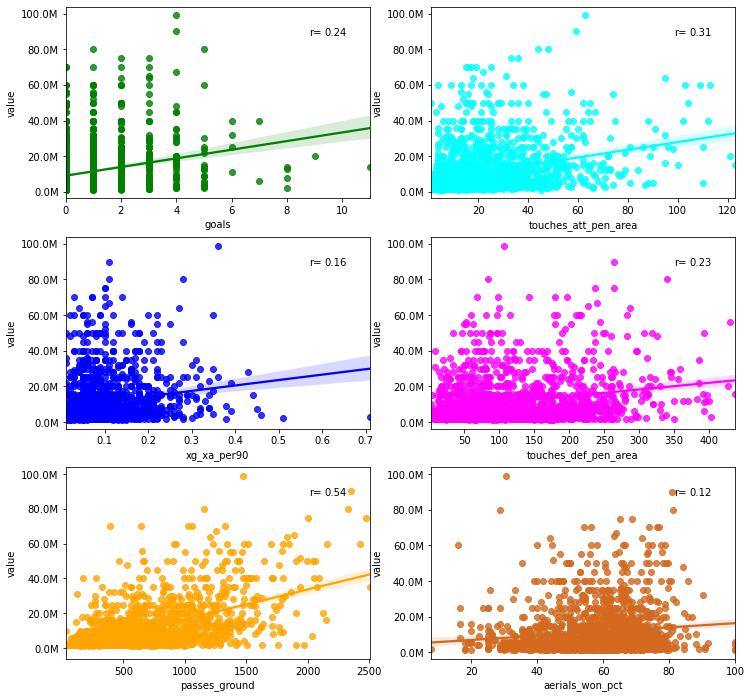

In [22]:
#applying millions formatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = mpl.ticker.FuncFormatter(millions)


#dataDEF=dataDEF[['goals','xg_xa_per90','passes_ground','touches_att_pen_area','touches_def_pen_area','aerials_won_pct']

#dataDEF=dataDEF[dataDEF['goals']>0]
dataDEF=dataDEF[dataDEF['xg_xa_per90']>0]
dataDEF=dataDEF[dataDEF['passes_ground']>0]
dataDEF=dataDEF[dataDEF['touches_att_pen_area']>0]
dataDEF=dataDEF[dataDEF['touches_def_pen_area']>0]
dataDEF=dataDEF[dataDEF['aerials_won_pct']>0]
lecimy1=np.corrcoef(dataDEF['value'],dataDEF['goals'])
lecimy2=np.corrcoef(dataDEF['value'],dataDEF['xg_xa_per90'])
lecimy3=np.corrcoef(dataDEF['value'],dataDEF['passes_ground'])
lecimy4=np.corrcoef(dataDEF['value'],dataDEF['touches_att_pen_area'])
lecimy5=np.corrcoef(dataDEF['value'],dataDEF['touches_def_pen_area'])
lecimy6=np.corrcoef(dataDEF['value'],dataDEF['aerials_won_pct'])
lecimy1=lecimy1[0,1]
lecimy2=lecimy2[0,1]
lecimy3=lecimy3[0,1]
lecimy4=lecimy4[0,1]
lecimy5=lecimy5[0,1]
lecimy6=lecimy6[0,1]

fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.regplot(ax=ax[0,0],x=dataDEF['goals'],y=dataDEF['value'],data=dataDEF,color='g')
sns.regplot(ax=ax[1,0],x=dataDEF['xg_xa_per90'],y=dataDEF['value'],data=dataDEF,color='blue')
sns.regplot(ax=ax[2,0],x=dataDEF['passes_ground'],y=dataDEF['value'],data=dataDEF,color='orange')
sns.regplot(ax=ax[0,1],x=dataDEF['touches_att_pen_area'],y=dataDEF['value'],data=dataDEF,color='cyan')
sns.regplot(ax=ax[1,1],x=dataDEF['touches_def_pen_area'],y=dataDEF['value'],data=dataDEF,color='magenta')
sns.regplot(ax=ax[2,1],x=dataDEF['aerials_won_pct'],y=dataDEF['value'],data=dataDEF,color='chocolate')

ax[0,0].yaxis.set_major_formatter(formatter)
ax[0,0].annotate("r=",xy=(0.8,0.85), xycoords="axes fraction")
ax[0,0].annotate("{:.2f}".format(lecimy1),xy=(0.85,0.85), xycoords="axes fraction")

ax[1,0].yaxis.set_major_formatter(formatter)
ax[1,0].annotate("r=",xy=(0.8,0.85), xycoords="axes fraction")
ax[1,0].annotate("{:.2f}".format(lecimy2),xy=(0.85,0.85), xycoords="axes fraction")

ax[2,0].yaxis.set_major_formatter(formatter)
ax[2,0].annotate("r=",xy=(0.8,0.85), xycoords="axes fraction")
ax[2,0].annotate("{:.2f}".format(lecimy3),xy=(0.85,0.85), xycoords="axes fraction")

ax[0,1].yaxis.set_major_formatter(formatter)
ax[0,1].annotate("r=",xy=(0.8,0.85), xycoords="axes fraction")
ax[0,1].annotate("{:.2f}".format(lecimy4),xy=(0.85,0.85), xycoords="axes fraction")

ax[1,1].yaxis.set_major_formatter(formatter)
ax[1,1].annotate("r=",xy=(0.8,0.85), xycoords="axes fraction")
ax[1,1].annotate("{:.2f}".format(lecimy5),xy=(0.85,0.85), xycoords="axes fraction")

ax[2,1].yaxis.set_major_formatter(formatter)
ax[2,1].annotate("r=",xy=(0.8,0.85), xycoords="axes fraction")
ax[2,1].annotate("{:.2f}".format(lecimy6),xy=(0.85,0.85), xycoords="axes fraction")